In [2]:
%matplotlib inline
import pylab as plt
from astrometry.util.fits import fits_table
import numpy as np
from collections import Counter

In [3]:
# python copilot.py --fits db.fits
T = fits_table('db.fits')
print(len(T), 'exposure')

81256 exposure


In [4]:
T.cut(T.expfactor > 0)
print(len(T), 'with positive expfactor')
E,I = np.unique(T.expnum, return_index=True)
print(len(np.unique(T.expnum)), 'unique expnums')
T.cut(I)
max_expfactor = 2.5
T.cut(T.expfactor < max_expfactor)
print(len(T), 'with good expfactor')
T.cut(T.expfactor > 0.2)
print(len(T), 'with good expfactor')
T.cut(T.exptime > 70)
print(len(T), 'with good exptime')
T.cut(T.obstype == 'object   ')
print(len(T), 'object exposures')
T.cut(np.argsort(T.mjd_obs))
T.cut(np.fmod(T.mjd_obs, 1.) < 0.6)
print(len(T), 'with good MJD_OBS')
T.night = T.mjd_obs.astype(int)

61672 with positive expfactor
61626 unique expnums
54818 with good expfactor
54693 with good expfactor
54177 with good exptime
54168 object exposures
54166 with good MJD_OBS


In [12]:
nights = np.unique(T.night)
print(len(nights), 'nights')

306 nights


In [5]:
goodnights = [k for k,v in Counter(T.night).most_common() if v > 50]
print(len(goodnights), 'good nights')
goodnights.sort()
I, = np.nonzero([n in goodnights for n in T.night])
print(len(I), 'exposures in good nights')
T.cut(I)

306 good nights
52625 exposures in good nights


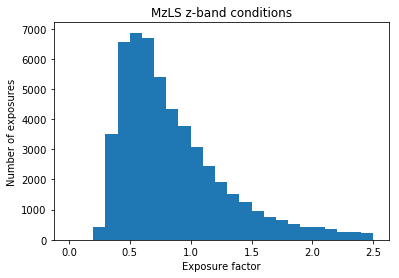

In [6]:
plt.clf()
plt.hist(T.expfactor, 25, range=(0,max_expfactor))#, log=True)
plt.xlabel('Exposure factor')
plt.ylabel('Number of exposures')
plt.title('MzLS z-band conditions');

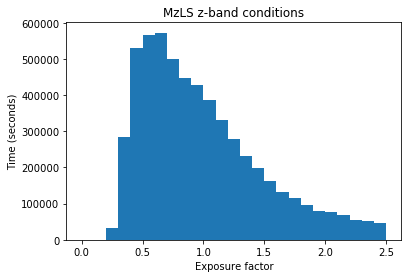

In [7]:
plt.clf()
plt.hist(T.expfactor, 25, range=(0,max_expfactor), weights=T.exptime) #log=True, 
plt.xlabel('Exposure factor')
plt.ylabel('Time (seconds)')
plt.title('MzLS z-band conditions');

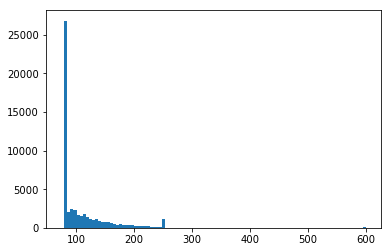

In [8]:
plt.hist(T.exptime, bins=100);

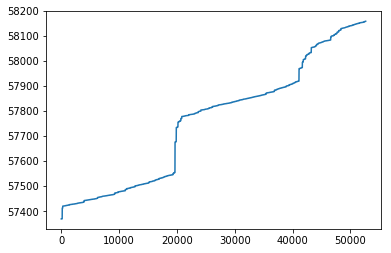

In [9]:
plt.plot(T.mjd_obs);

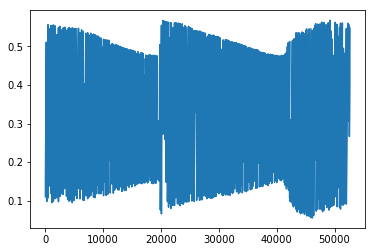

In [10]:
plt.plot(np.fmod(T.mjd_obs, 1.));

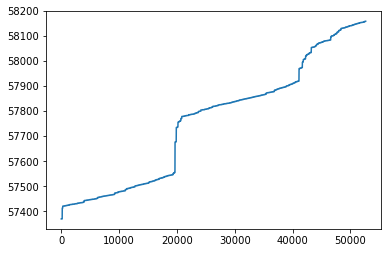

In [11]:
plt.plot(T.mjd_obs.astype(int));

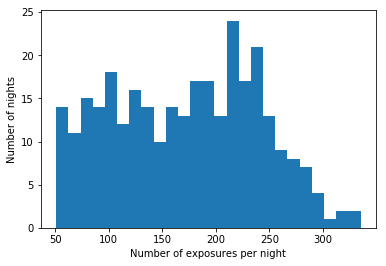

In [13]:
exposures_per_night = [v for k,v in Counter(T.night).most_common()]
plt.hist(exposures_per_night, 25);
plt.xlabel('Number of exposures per night')
plt.ylabel('Number of nights');

In [14]:
# Gather some stats per night
nights = fits_table()
nights.nights = goodnights
nights.exposures = []
nights.exptime_sum = []
nights.exptime_avg = []
nights.expfactor_avg = []
for n in nights.nights:
    I = np.flatnonzero(T.night == n)
    nights.exposures.append(I)
    nights.exptime_sum.append(np.sum(T.exptime[I]))
    nights.exptime_avg.append(np.mean(T.exptime[I]))
    nights.expfactor_avg.append(np.mean(T.expfactor[I]))

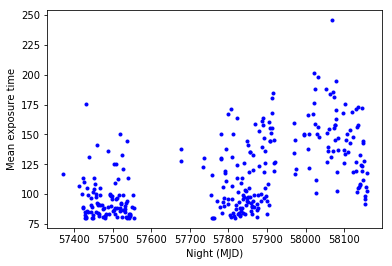

In [15]:
plt.plot(nights.nights, nights.exptime_avg, 'b.');
plt.xlabel('Night (MJD)')
plt.ylabel('Mean exposure time');

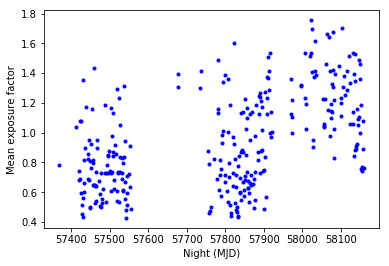

In [16]:
plt.plot(nights.nights, nights.expfactor_avg, 'b.');
plt.xlabel('Night (MJD)')
plt.ylabel('Mean exposure factor');

Total exptime available: 5670281.037
Nominal exposure time for perfect strategy: 125.626521854
Total perfect exptime: 5670281.037
Nominal exposure time for lag2 strategy: 126.464304474
Total lag2 exptime: 5.67028e+06
Nominal exposure time for lag1 strategy: 126.134046787
Total lag1 exptime: 5.67028e+06


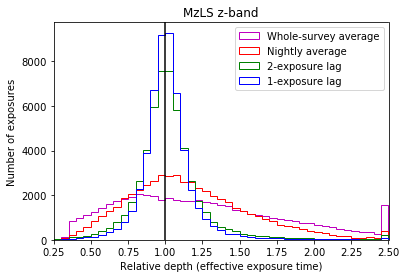

In [46]:
# Now compute depth factors for different adaptive strategies.
# "depths" here are actually effective exposure times.

print('Total exptime available:', np.sum(T.exptime))

# Nominal exposure time for "perfect" strategy
exptime_perfect = np.sum(T.exptime) / np.mean(T.expfactor) / len(T)
print('Nominal exposure time for perfect strategy:', exptime_perfect)
# Perfect strategy
exptimes_perfect = exptime_perfect * T.expfactor
print('Total perfect exptime:', np.sum(exptimes_perfect))
depth_perfect = exptimes_perfect / T.expfactor

# Survey-wide average exposure time
exptime_fixed = np.mean(T.exptime)
# Whole-survey fixed exposure-time strategy
depth_survey = exptime_fixed / T.expfactor

exptimes_nightly = np.zeros(len(T), np.float32)
depth_nightly = np.zeros(len(T), np.float32)

expfactors_lag2 = np.zeros(len(T), np.float32)
expfactors_lag1 = np.zeros(len(T), np.float32)

# Compute per-night stats
for i in range(len(nights)):
    I = nights.exposures[i]
    Ti = T[I]

    # Nightly average exposure time strategy
    exptime = nights.exptime_avg[i]
    exptimes_nightly[I] = exptime
    depth_nightly[I] = exptime / Ti.expfactor

    # 2-exposure lag
    expfactor = np.zeros(len(Ti), np.float32)
    expfactor[:2] = np.mean(T.expfactor)
    expfactor[2:] = Ti.expfactor[:-2]
    expfactors_lag2[I] = expfactor

    # 1-exposure lag
    expfactor = np.zeros(len(Ti), np.float32)
    expfactor[0] = np.mean(T.expfactor)
    expfactor[1:] = Ti.expfactor[:-1]
    expfactors_lag1[I] = expfactor

# Nominal exposure time for "lag2" strategy
exptime_lag2 = np.sum(T.exptime) / np.mean(expfactors_lag2) / len(T)
print('Nominal exposure time for lag2 strategy:', exptime_lag2)
exptimes_lag2 = exptime_lag2 * expfactors_lag2
print('Total lag2 exptime:', np.sum(exptimes_lag2))
depth_lag2 = exptimes_lag2 / T.expfactor

# Nominal exposure time for "lag1" strategy
exptime_lag1 = np.sum(T.exptime) / np.mean(expfactors_lag1) / len(T)
print('Nominal exposure time for lag1 strategy:', exptime_lag1)
exptimes_lag1 = exptime_lag1 * expfactors_lag1
print('Total lag1 exptime:', np.sum(exptimes_lag1))
depth_lag1 = exptimes_lag1 / T.expfactor

plt.clf()
#lo,hi = 0, 250
lo,hi = 0, 2.5
ha = dict(range=(lo,hi), bins=50, histtype='step')
p = depth_perfect[0]
#n1,b1,p1 = plt.hist(np.clip(depth_perfect, lo, hi), color='b', **ha)
plt.axvline(depth_perfect[0]/p, color='k')
n1,b1,p1 = plt.hist(np.clip(depth_survey/p, lo, hi), color='m', **ha);
n2,b2,p2 = plt.hist(np.clip(depth_nightly/p, lo, hi), color='r', **ha);
n3,b3,p3 = plt.hist(np.clip(depth_lag2/p, lo, hi), color='g', **ha);
n4,b4,p4 = plt.hist(np.clip(depth_lag1/p, lo, hi), color='b', **ha);
plt.ylim(0, max(max(n2), max(n3), max(n4))*1.05);
plt.legend((p1[0], p2[0], p3[0], p4[0]),
           ('Whole-survey average', 'Nightly average', '2-exposure lag', '1-exposure lag'));
plt.title('MzLS z-band')
plt.ylabel('Number of exposures')
plt.xlabel('Relative depth (effective exposure time)');
plt.xlim(0.25, hi);
plt.savefig('money.png')

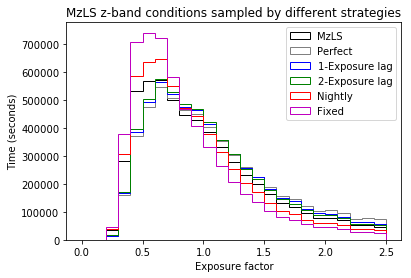

In [50]:
plt.clf()
ha = dict(bins=25, range=(0,max_expfactor), histtype='step')
plt.hist(T.expfactor, weights=T.exptime, color='k', label='MzLS', **ha)
plt.hist(T.expfactor, weights=exptimes_perfect, color='0.5', label='Perfect', **ha)
plt.hist(T.expfactor, weights=exptimes_lag1, color='b', label='1-Exposure lag', **ha)
plt.hist(T.expfactor, weights=exptimes_lag2, color='g', label='2-Exposure lag', **ha)
plt.hist(T.expfactor, weights=exptimes_nightly, color='r', label='Nightly', **ha)
plt.hist(T.expfactor, weights=np.zeros_like(T.exptime)+exptime_fixed, color='m', label='Fixed', **ha)
plt.xlabel('Exposure factor')
plt.ylabel('Time (seconds)')
plt.legend()
plt.title('MzLS z-band conditions sampled by different strategies');
plt.savefig('conditions.pdf')

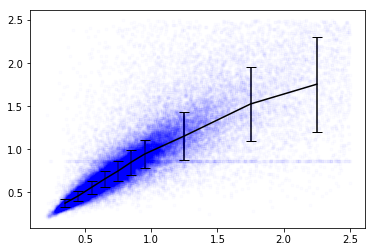

In [40]:
bins = np.hstack((np.arange(0.3, 1.0, 0.1), np.arange(1.0, 2.51, 0.5)))
avg_lag1, sig_lag1 = [],[]
avg_lag2, sig_lag2 = [],[]
cbins = (bins[:-1] + bins[1:])/2.
for lo,hi in zip(bins, bins[1:]):
    I = np.flatnonzero((T.expfactor >= lo) * (T.expfactor < hi))
    e = expfactors_lag1[I]
    pcts = np.percentile(e, [16,50,84])
    avg_lag1.append(pcts[1])
    sig_lag1.append((pcts[2]-pcts[0])/2.)
    e = expfactors_lag2[I]
    pcts = np.percentile(e, [16,50,84])
    avg_lag2.append(pcts[1])
    sig_lag2.append((pcts[2]-pcts[0])/2.)
    

plt.plot(T.expfactor, expfactors_lag2, 'b.', alpha=0.01);
ax = plt.axis()
plt.errorbar(cbins, avg_lag2, yerr=sig_lag2, ecolor='k', capsize=5, color='k')
plt.axis(ax);

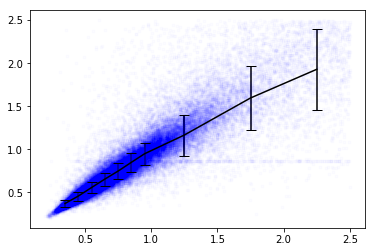

In [41]:
plt.plot(T.expfactor, expfactors_lag1, 'b.', alpha=0.01);
ax = plt.axis()
plt.errorbar(cbins, avg_lag1, yerr=sig_lag1, ecolor='k', capsize=5, color='k')
plt.axis(ax);

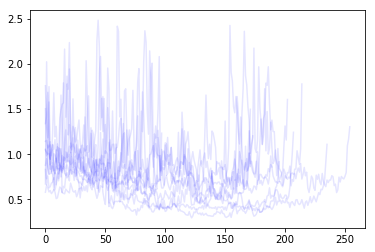

In [30]:
for night in nights[50:60]:
    plt.plot(T.expfactor[night.exposures], 'b-', alpha=0.1)

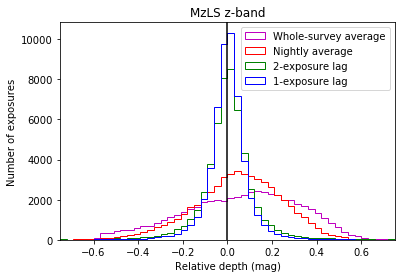

In [31]:
def time_to_mag(depth):
    p = depth_perfect[0]
    time = depth / p
    # S/N ~ time^2
    sn = np.sqrt(time)
    dmag = 2.5 * np.log10(sn)
    return dmag
    
plt.clf()
lo,hi = -0.75, 0.75
ha = dict(range=(lo,hi), bins=50, histtype='step')
plt.axvline(time_to_mag(depth_perfect[0]), color='k')
n1,b1,p1 = plt.hist(np.clip(time_to_mag(depth_survey), lo, hi), color='m', **ha);
n2,b2,p2 = plt.hist(np.clip(time_to_mag(depth_nightly), lo, hi), color='r', **ha);
n3,b3,p3 = plt.hist(np.clip(time_to_mag(depth_lag2), lo, hi), color='g', **ha);
n4,b4,p4 = plt.hist(np.clip(time_to_mag(depth_lag1), lo, hi), color='b', **ha);
plt.ylim(0, max(max(n2), max(n3), max(n4))*1.05);
plt.legend((p1[0], p2[0], p3[0], p4[0]),
           ('Whole-survey average', 'Nightly average', '2-exposure lag', '1-exposure lag'));
plt.title('MzLS z-band')
plt.ylabel('Number of exposures')
plt.xlabel('Relative depth (mag)');
plt.xlim(lo,hi)
plt.savefig('money-mag.pdf')